(pathfinder)=

# Pathfinder Variational Inference

:::{post} Feb 5, 2023 
:tags: variational inference, jax 
:category: advanced, how-to
:author: Thomas Wiecki
:::

Pathfinder {cite:p}`zhang2021pathfinder` is a variational inference algorithm that produces samples from the posterior of a Bayesian model. It compares favorably to the widely used ADVI algorithm. On large problems, it should scale better than most MCMC algorithms, including dynamic HMC (i.e. NUTS), at the cost of a more biased estimate of the posterior. For details on the algorithm, see the [arxiv preprint](https://arxiv.org/abs/2108.03782).

This algorithm is [implemented](https://github.com/blackjax-devs/blackjax/pull/194) in [BlackJAX](https://github.com/blackjax-devs/blackjax), a library of inference algorithms for [JAX](https://github.com/google/jax). Through PyMC's JAX-backend (through [pytensor](https://github.com/pytensor-devs/pytensor)) we can run BlackJAX's pathfinder on any PyMC model with some simple wrapper code.

This wrapper code is implemented in [pymc-extras](https://github.com/pymc-devs/pymc-extras/). This tutorial shows how to run Pathfinder on your PyMC model.

You first need to install `pymc-extras`:

`pip install git+https://github.com/pymc-devs/pymc-extras`

Instructions for installing other packages:  
- [jax](https://github.com/google/jax#installation)
- [blackjax](https://pypi.org/project/blackjax/)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_extras as pmx

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.20.1+3.gce5f2a271


First, define your PyMC model. Here, we use the 8-schools model.

In [2]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    tau = pm.HalfCauchy("tau", 5.0)

    z = pm.Normal("z", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * z)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, shape=J, observed=y)

Next, we call `pmx.fit()` and pass in the algorithm we want it to use.

In [3]:
rng = np.random.default_rng(123)
with model:
    idata_ref = pm.sample(target_accept=0.9, random_seed=rng)
    idata_path = pmx.fit(
        method="pathfinder",
        jitter=12,
        num_draws=1000,
        random_seed=123,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Output()

Pathfinder Results                          
                                            
  No. model parameters     10               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    7                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   12               
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 22 ± std 6  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 8 ± std 9   
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.75             
                                            
  Timing (seconds):                         
  Compile                  4.94             
  Compute                  0.25             
  Total                    5.19

Just like `pymc.sample()`, this returns an idata with samples from the posterior. Note that because these samples do not come from an MCMC chain, convergence can not be assessed in the regular way.

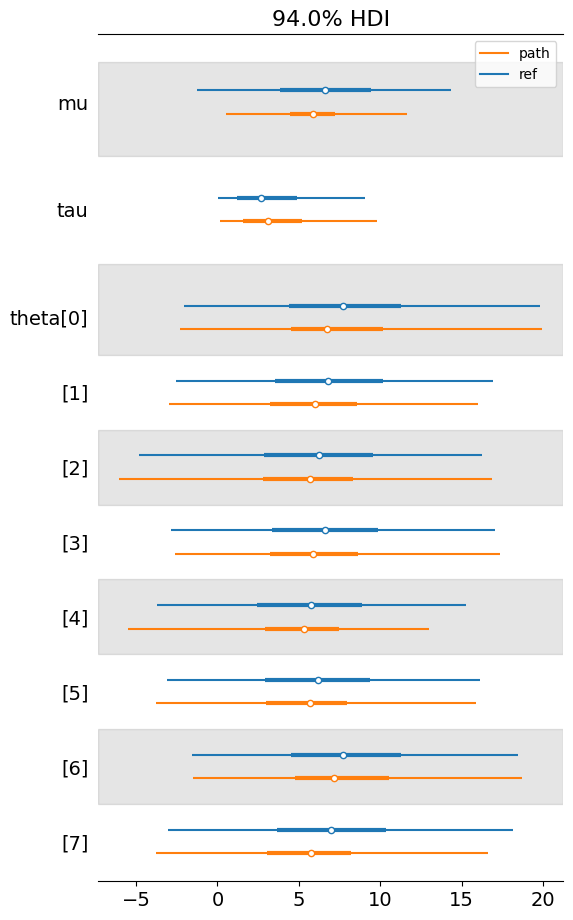

In [4]:
az.plot_forest(
    [idata_ref, idata_path],
    var_names=["~z"],
    model_names=["ref", "path"],
    combined=True,
);

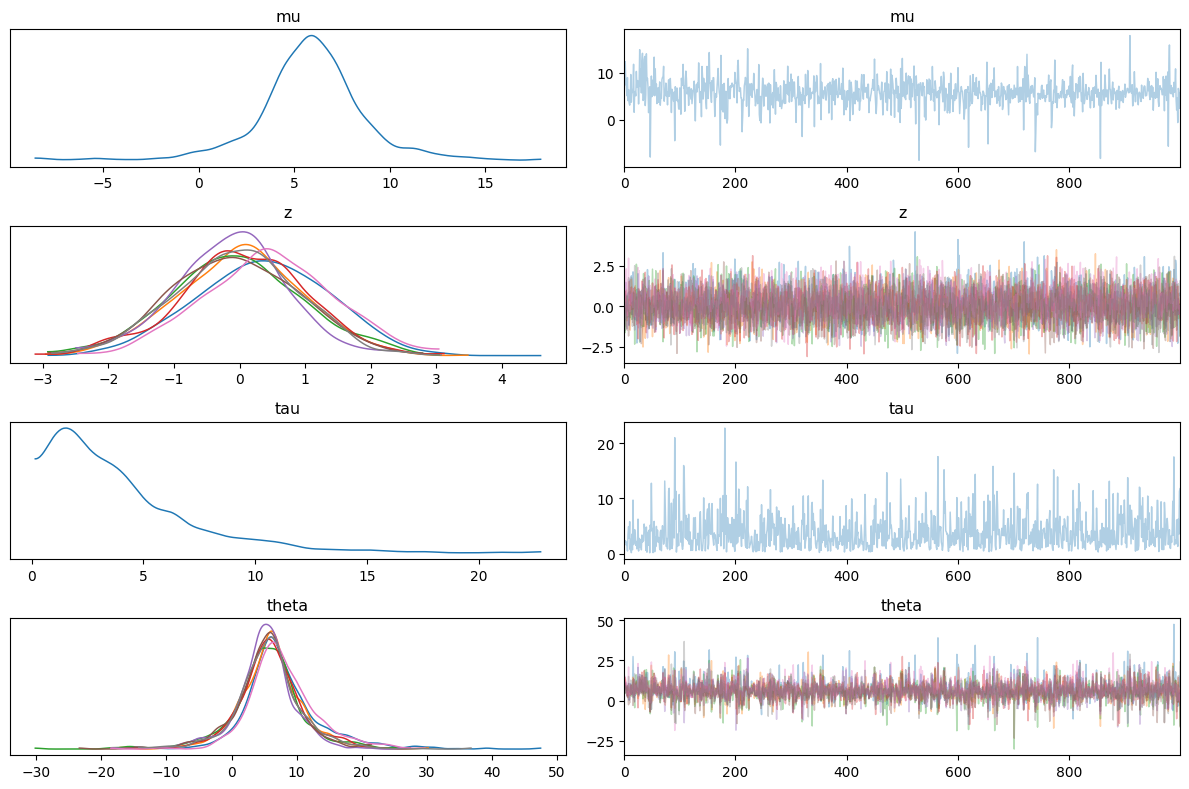

In [5]:
az.plot_trace(idata_path)
plt.tight_layout();

## References

:::{bibliography}
:filter: docname in docnames
:::

## Authors

* Authored by Thomas Wiecki on Oct 11 2022 ([pymc-examples#429](https://github.com/pymc-devs/pymc-examples/pull/429))
* Re-execute notebook by Reshama Shaikh on Feb 5, 2023
* Bug fix by Chris Fonnesbeck on Jul 17, 2024

## Watermark

In [6]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Thu Feb 13 2025

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.31.0

xarray: 2025.1.1

pymc_extras: 0.2.3
arviz      : 0.20.0
matplotlib : 3.10.0
numpy      : 1.26.4
pymc       : 5.20.0+15.g5f3f5ec5c

Watermark: 2.5.0



:::{include} ../page_footer.md
:::